# GHCN Analysis

In [1]:
import os
from glob import glob

import dask
import dask.bag as db
import dask.dataframe as dd
from distributed import Client
from dask_jobqueue import SLURMCluster

from IPython.display import display
import matplotlib.pyplot as plt

from ghcn import load_daily
import numpy as np

In [2]:
# Set LOCAL to True for single-machine execution while developing
# Set LOCAL to False for cluster execution
LOCAL = False

if LOCAL:
    # This line creates a single-machine dask client
    client = Client()
else:    
    # This line creates a SLURM cluster dask and dask client
    # Logging outputs will be stored in /scratch/{your-netid}
    
    cluster = SLURMCluster(memory='4GB', cores=2, python='/scratch/work/public/dask/bin/python', 
                               local_directory='/tmp/{}/'.format(os.environ['SLURM_JOB_USER']),
                               job_extra=['--output=/scratch/{}/slurm-%j.out'.format(os.environ['SLURM_JOB_USER'])])

    cluster.submit_command = 'slurm'
    cluster.scale(100)

    display(cluster)
    client = Client(cluster)

display(client)

Client Scheduler: tcp://10.32.33.83:46425 Dashboard: http://10.32.33.83:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
# Get a list of all input files
# We'll sort them alphabetically to ensure reproducibility

sm_files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_tiny/*.dly'))
md_files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_small/*.dly'))
al_files = sorted(glob('/scratch/work/courses/DSGA1004-2021/ghcnd_all/*.dly'))

# Load in a single file to demonstrate the parser
# Just print out the first few records to illustrate the structure
#load_daily(files[0])

In [6]:
def do_process(inpt, outpt):
    # Load daily files into bags
    partitions = int(len(inpt)/50)
    if partitions < 1:
        partitions = 1

    print(f'Using {partitions} partitions for {len(inpt)} rows')   
    bag = db.from_sequence(inpt, npartitions=partitions).map(load_daily)
    
    # TMAX
    bag_tmax = bag.flatten().filter(lambda daily: daily['element'] == 'TMAX' and daily['value'] != -9999 and daily['quality'] == ' ')
    df_tmax = bag_tmax.to_dataframe(meta={'year': int, 'value': float})
    df_tmax = df_tmax.groupby('year').max()

    #PRCP
    bag_prcp = bag.flatten().filter(lambda daily: daily['element'] == 'PRCP' and daily['value'] != -9999 and daily['quality'] == ' ')
    df_prcp = bag_prcp.to_dataframe(meta={'year': int, 'value': float})
    df_prcp = df_prcp.groupby('year').mean()

    tmax_name = 'tmax-' + outpt + '.csv'
    prcp_name = 'prcp-' + outpt + '.csv'
    print("saving csvs")
    df_tmax.to_csv(tmax_name, single_file=True)
    df_prcp.to_csv(prcp_name, single_file=True)
    
    import pandas as pd
    print("generating charts")
    chart_prcp = pd.read_csv(prcp_name)
    plt.scatter(chart_prcp['year'],chart_prcp['value'])
    plt.title(f'mean prcp {outpt}')
    plt.ylabel('prcp')
    plt.xlabel('Year')
    plt.savefig(f'mean_prcp_{outpt}')
    plt.show()
    
    chart_temp = pd.read_csv(tmax_name)
    plt.scatter(chart_temp['year'],chart_temp['value'], c = 'r')
    plt.title(f'max temp {outpt}')
    plt.ylabel('temperature')
    plt.xlabel('Year')
    plt.savefig(f'max_temp_{outpt}')
    plt.show()

Doing tiny...
Using 1 partitions for 50 rows
saving csvs
generating charts


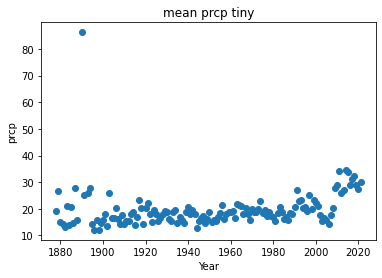

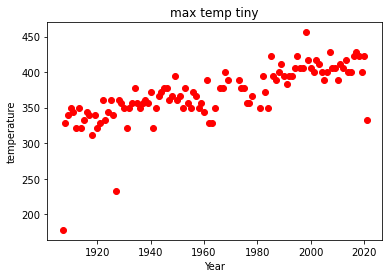

In [7]:
print("Doing tiny...")
do_process(sm_files, "tiny")

Doing small...
Using 20 partitions for 1000 rows
saving csvs
generating charts


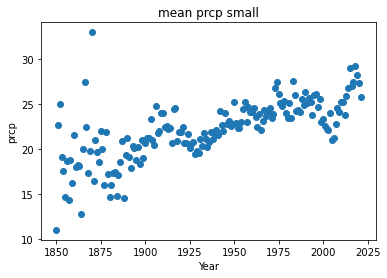

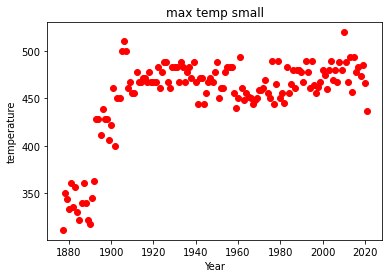

In [8]:
print("Doing small...")
do_process(md_files, "small")

Doing all...
Using 2369 partitions for 118487 rows
saving csvs
generating charts


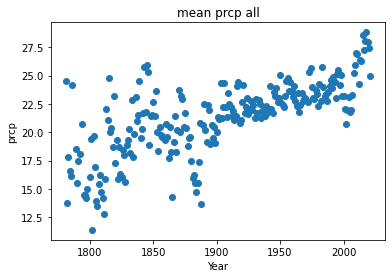

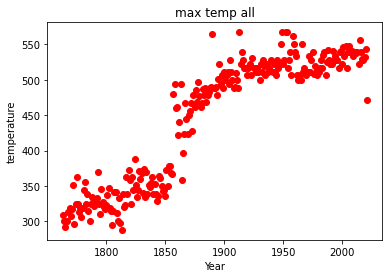

In [9]:
print("Doing all...")
do_process(al_files, "all")